## Defense study - 1
This jupyter notebook creates plots to study the impact of upgrading/new stations near max waiting


### 0. Analysis IDs to compare

In [1]:
# Define the set id for the analysis_ids that we want to compare
set_id  = (102, 104, 105, 106, 107, 108, 109 )

### 1. Package Installs

In [2]:
# python-dtenv to read the env variables
#!pip install python-dotenv

In [3]:
# Seaborn for plotting
#!pip install seaborn

In [4]:
#!pip install xarray

In [5]:
# Plotly for plotting 
#!pip install plotly

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import os
import psycopg2
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px
import xarray as xr
import plotly.data as pdata
from barchart3d import barchart3d

### 2. Environment Variables

In [7]:
# Load the environment variables
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [8]:
# Print this to see if the env variables are read now
os.getenv("COMPOSE_PROJECT_NAME")

'evidss'

### 3. Database connection

In [9]:
# Generic function to test the connection to the database
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(    
            host=os.getenv("MAIN_HOST"),
            database=os.getenv("MAIN_DB"),
            user=os.getenv("DBREAD_USER"),
            password=os.getenv("DBREAD_PWD"), 
            port = os.getenv("MAIN_PORT")
        )
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [10]:
# Make the test database connection
connect()

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 13.2 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',)
Database connection closed.


In [46]:
conn = psycopg2.connect(    
    host=os.getenv("MAIN_HOST"),
    database=os.getenv("MAIN_DB"),
    user=os.getenv("DBREAD_USER"),
    password=os.getenv("DBREAD_PWD"), 
    port = os.getenv("MAIN_PORT")
)

# create a cursor
cur = conn.cursor()

### 4. Database queries

In [12]:
cur.execute('select count(veh_id) from wa_bevs')
evs_in_wa = cur.fetchone()
evs_in_wa

(46727,)

In [13]:
sql_evs_in_sim = 'select count(veh_id), analysis_id from evtrip_scenarios where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_in_sim, (analysis_ids,))
evs_in_sim = pd.read_sql_query(sql=sql_evs_in_sim, con=conn, params=(set_id,))
evs_in_sim

,count,analysis_id
0,858,509
1,878,529
2,900,502
3,885,506
4,904,508
5,886,512
6,904,523
7,878,534
8,880,501
9,920,528


In [14]:
sql_evs_fin = 'select count(veh_id), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_fin, (analysis_ids,))
evs_fin = pd.read_sql_query(sql=sql_evs_fin, con=conn, params=(set_id,))
evs_fin

,count,analysis_id
0,852,509
1,872,529
2,899,502
3,879,506
4,902,508
5,882,512
6,903,523
7,872,534
8,876,501
9,918,528


In [15]:
sql_evs_str = 'select count(veh_id), analysis_id from ev_stranded where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_str, (analysis_ids,)) # Uncomment for debugging the query
evs_str = pd.read_sql_query(sql=sql_evs_str, con=conn, params=(set_id,))
evs_str

,count,analysis_id
0,8,511
1,6,514
2,1,513
3,6,509
4,4,504
5,1,518
6,6,529
7,7,500
8,4,522
9,1,502


In [16]:
sql_evs_str_loc = '''select stranded_lat, stranded_lng, est.analysis_id, coalesce(ne.count, 0) as nevse_count
from ev_stranded est
         left join (
    select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on est.analysis_id = ne.analysis_id
where est.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
ORDER BY nevse_count;'''
evs_str_loc = pd.read_sql_query(sql=sql_evs_str_loc, con=conn, params=(set_id,))
evs_str_loc.head()

,stranded_lat,stranded_lng,analysis_id,nevse_count
0,45.914108,-120.706280,501,0
1,46.915788,-121.378889,504,0
2,47.526043,-120.305365,501,0
3,47.752463,-122.890681,503,0
4,47.856432,-121.952257,501,0


In [17]:
sql_evmt = 'select sum(distance_travelled), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evmt, (analysis_ids,))
evmt = pd.read_sql_query(sql=sql_evmt, con=conn, params=(set_id,))
evmt

,sum,analysis_id
0,99364.0,509
1,103274.0,529
2,104307.0,502
3,104912.0,506
4,104724.0,508
5,103596.0,512
6,104921.0,523
7,103273.0,534
8,102984.0,501
9,107898.0,528


In [18]:
sql_cs = 'select count(cs_id), analysis_id from evse_charging_session where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_cs, (analysis_ids,))
cs = pd.read_sql_query(sql=sql_cs, con=conn, params=(set_id,))
cs

,count,analysis_id
0,586,509
1,631,529
2,575,502
3,603,506
4,583,508
5,583,512
6,589,523
7,635,534
8,569,501
9,619,528


In [19]:
sql_ws = 'select count(wait_id), analysis_id from evse_evs_waiting where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_ws, (analysis_ids,))
ws = pd.read_sql_query(sql=sql_ws, con=conn, params=(set_id,))
ws

,count,analysis_id
0,16,509
1,71,529
2,124,500
3,100,502
4,106,525
5,22,506
6,25,508
7,102,531
8,28,512
9,82,523


In [20]:
# basecase_aid = 438
sql_evse_util = """SELECT epd.analysis_id,
       epd.simulation_ts::timestamp as datetime,
       sum(epd.power_val)           as total_power,
       coalesce(ne.count, 0)               as nevse_count
FROM evse_power_draw epd
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on epd.analysis_id = ne.analysis_id
WHERE epd.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
GROUP BY epd.simulation_ts, epd.analysis_id, nevse_count
ORDER BY nevse_count, epd.simulation_ts::timestamp;"""
# cur.mogrify(sql_evse_util, (analysis_ids,))
evse_util = pd.read_sql_query(sql=sql_evse_util, con=conn, params=(set_id,))
evse_util

,analysis_id,datetime,total_power,nevse_count
0,503,2019-07-01 06:00:27,0,0
1,501,2019-07-01 06:00:45,0,0
2,500,2019-07-01 06:00:56,0,0
3,504,2019-07-01 06:01:22,0,0
4,503,2019-07-01 06:01:27,0,0
...,...,...,...,...
37894,530,2019-07-02 08:30:22,0,5
37895,530,2019-07-02 08:31:22,0,5
37896,530,2019-07-02 08:32:22,0,5
37897,530,2019-07-02 08:33:22,0,5


In [21]:
sql_seeds = """select param_value as seed, analysis_id from analysis_params where analysis_id IN (select analysis_id from analysis_record where set_id = 102 order by analysis_id) and param_id = 1;"""
seeds = pd.read_sql_query(sql=sql_seeds, con=conn)['seed'].tolist()
# a_ids = a_ids[:-1]
seeds

['410', '600', '210', '577', '103']

In [22]:
sql_aids = """select analysis_id from analysis_record where set_id IN %s order by analysis_id"""
a_ids = pd.read_sql_query(sql=sql_aids, con=conn, params=(set_id,))['analysis_id'].tolist()
# a_ids = a_ids[:-1]
a_ids

[500,
 501,
 502,
 503,
 504,
 506,
 507,
 508,
 509,
 510,
 511,
 512,
 513,
 514,
 515,
 516,
 517,
 518,
 519,
 520,
 521,
 522,
 523,
 524,
 525,
 526,
 527,
 528,
 529,
 530,
 531,
 532,
 533,
 534,
 535]

In [25]:
# basecase_aid = 438
sql_count_stats = """select count(ets.veh_id) as sim_count,
       ets.analysis_id,
       coalesce(ne.count, 0) as nevse_count,
       ef.fin_count,
       ef.evmt,
       es.str_count,
       ecs.cs_count,
       ew.wait_count
from evtrip_scenarios ets
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on ets.analysis_id = ne.analysis_id
         join (select count(veh_id) as fin_count, sum(distance_travelled) as evmt, analysis_id
               from ev_finished
               group by analysis_id) as ef
              on ets.analysis_id = ef.analysis_id
         join (select count(veh_id) as str_count, analysis_id from ev_stranded group by analysis_id) as es
              on ets.analysis_id = es.analysis_id
         join (select count(cs_id) as cs_count, analysis_id from evse_charging_session group by analysis_id) as ecs
              on ets.analysis_id = ecs.analysis_id
join (select count(wait_id) as wait_count, analysis_id from evse_evs_waiting group by analysis_id) as ew
              on ets.analysis_id = ew.analysis_id
where ets.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
group by ets.analysis_id, nevse_count, ef.fin_count, es.str_count, ef.evmt, ecs.cs_count, ew.wait_count
order by ets.analysis_id desc
;"""
count_stats = pd.read_sql_query(sql=sql_count_stats, con=conn, params=(set_id,))
#count_stats.sort_values(by=['analysis_id'], inplace=True)
count_stats

,sim_count,analysis_id,nevse_count,fin_count,evmt,str_count,cs_count,wait_count
0,907,535,5,903,106924.0,4,665,78
1,878,534,5,872,103273.0,6,635,58
2,920,533,5,919,108116.0,1,630,71
3,900,532,5,897,106578.0,3,620,69
4,911,531,5,904,109790.0,7,708,102
5,907,530,5,903,106932.0,4,677,101
6,878,529,5,872,103274.0,6,631,71
7,920,528,5,918,107898.0,2,619,75
8,900,527,5,897,106583.0,3,632,64
9,911,526,5,905,109913.0,6,695,107


In [26]:
# count_stats.dtypes
# count_stats = count_stats.sort_values(by=['nevse_count'])
# count_stats

In [27]:
sql_comp_stats = """select lai.action_tstamp_tx                                               as start_time,
       lau.aid,
       lau.action_tstamp_tx                                               as end_time_tripgen,
       las.action_tstamp_tx,
       '# EV: ' || es.ev_count as ev_count,
       coalesce(ne.count, 0) as nevse_count,
       ((DATE_PART('day', lau.action_tstamp_tx - lai.action_tstamp_tx) * 24 +
         DATE_PART('hour', lau.action_tstamp_tx - lai.action_tstamp_tx)) * 60 +
        DATE_PART('minute', lau.action_tstamp_tx - lai.action_tstamp_tx)) as time_taken_tripgen,
       ((DATE_PART('day', las.action_tstamp_tx - lau.action_tstamp_tx) * 24 +
         DATE_PART('hour', las.action_tstamp_tx - lau.action_tstamp_tx)) * 60 +
        DATE_PART('minute', las.action_tstamp_tx - lau.action_tstamp_tx)) as time_taken_eviabm
from audit.logged_actions lai
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'trips_generated') as lau
              on lau.aid = lai.row_data -> 'analysis_id'
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'solved') as las
              on las.aid = lai.row_data -> 'analysis_id'
         join (select count(veh_id) as ev_count, analysis_id from public.evtrip_scenarios group by analysis_id) as es
              on es.analysis_id = (lai.row_data -> 'analysis_id')::int
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on (lai.row_data -> 'analysis_id')::int = ne.analysis_id
where lai.action = 'I'
  and lai.row_data -> 'analysis_id' ~* (select string_agg(cast(analysis_id as text), '|') from analysis_record where set_id IN %s)
ORDER BY nevse_count
;"""
# data = '|'.join(map(str,set_id))
comp_stats = pd.read_sql_query(sql=sql_comp_stats, con=conn, params=(set_id,))
comp_stats

,start_time,aid,end_time_tripgen,action_tstamp_tx,ev_count,nevse_count,time_taken_tripgen,time_taken_eviabm
0,2021-04-14 22:36:47.010014+00:00,503,2021-04-14 22:50:21.279622+00:00,2021-04-15 01:57:44.459085+00:00,# EV: 857,0,13.0,187.0
1,2021-04-14 22:36:40.681573+00:00,501,2021-04-14 22:50:21.409969+00:00,2021-04-15 02:24:14.703710+00:00,# EV: 880,0,13.0,213.0
2,2021-04-14 22:36:37.484010+00:00,500,2021-04-14 22:50:22.202472+00:00,2021-04-15 02:40:23.903212+00:00,# EV: 881,0,13.0,230.0
3,2021-04-14 22:36:43.845769+00:00,502,2021-04-14 22:51:19.139308+00:00,2021-04-15 02:32:15.450557+00:00,# EV: 900,0,14.0,220.0
4,2021-04-14 22:36:50.224210+00:00,504,2021-04-14 22:51:47.288835+00:00,2021-04-15 02:19:22.113497+00:00,# EV: 884,0,14.0,207.0
5,2021-04-15 00:13:45.268208+00:00,512,2021-04-15 00:54:20.059087+00:00,2021-04-15 05:00:17.236906+00:00,# EV: 886,5,40.0,245.0
6,2021-04-15 00:12:17.477602+00:00,507,2021-04-15 00:54:42.455088+00:00,2021-04-15 04:31:41.515499+00:00,# EV: 886,5,42.0,216.0
7,2021-04-15 00:12:20.678137+00:00,508,2021-04-15 00:57:27.611088+00:00,2021-04-15 04:45:11.694951+00:00,# EV: 904,5,45.0,227.0
8,2021-04-15 00:12:14.217535+00:00,506,2021-04-15 00:57:59.894191+00:00,2021-04-15 04:24:35.438276+00:00,# EV: 885,5,45.0,206.0
9,2021-04-15 00:13:51.662272+00:00,514,2021-04-15 00:58:09.663092+00:00,2021-04-15 04:35:45.358543+00:00,# EV: 858,5,44.0,217.0


## Find charging stations with max waiting sessions

In [28]:
basecase_aid = 484
sql_be_ws = """select count(wait_id) as count, analysis_id, evse_id, be.latitude, be.longitude
from evse_evs_waiting ews
         left join built_evse be on
    'b' || cast(be.bevse_id as text) = ews.evse_id
where ews.analysis_id = 484
group by ews.analysis_id, ews.evse_id, be.latitude, be.longitude
order by count desc
limit 5;
"""
be_ws = pd.read_sql_query(sql=sql_be_ws, con=conn, params=(basecase_aid,))
be_ws.head()

,count,analysis_id,evse_id,latitude,longitude
0,27,484,b73433,47.420940,-121.411300
1,26,484,b167497,47.188833,-120.903139
2,13,484,b105362,47.467463,-120.336918
3,9,484,b99297,46.994236,-120.549197
4,7,484,b143835,46.679874,-122.977158


In [29]:
sql_ne_ws = """select ne.latitude, ne.longitude, ne.analysis_id
from new_evses ne
where analysis_id IN ((select analysis_id from analysis_record where set_id = 106 limit 1)
                      UNION
                      (select analysis_id
                       from analysis_record
                       where set_id = 108
                       limit 1));"""
ne_ws = pd.read_sql_query(sql=sql_ne_ws, con=conn)
ne_ws

,latitude,longitude,analysis_id
0,47.429,-121.61,520
1,47.199,-120.96,520
2,47.539,-120.52,520
3,47.083,-120.74,520
4,46.706,-122.97,520
5,47.258,-121.21,526
6,47.076,-120.71,526
7,47.472,-120.32,526
8,46.947,-119.97,526
9,46.584,-122.89,526


In [47]:
sql_all_be_cs = """select be.latitude, be.longitude
from built_evse be where dcfc_count > 0 and connector_code IN (1, 2, 3);"""
all_be_cs = pd.read_sql_query(sql=sql_all_be_cs, con=conn)
all_be_cs.head()

,latitude,longitude
0,48.755607,-122.454132
1,47.458466,-122.333257
2,48.102863,-123.342273
3,47.207367,-122.294997
4,47.448354,-122.218800


### 5. Plotting

#### 5.1 Vehicle Counts

In [30]:
count_stats[(500 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 504)].sort_values('analysis_id')['sim_count']

34    881
33    880
32    900
31    857
30    884
Name: sim_count, dtype: int64

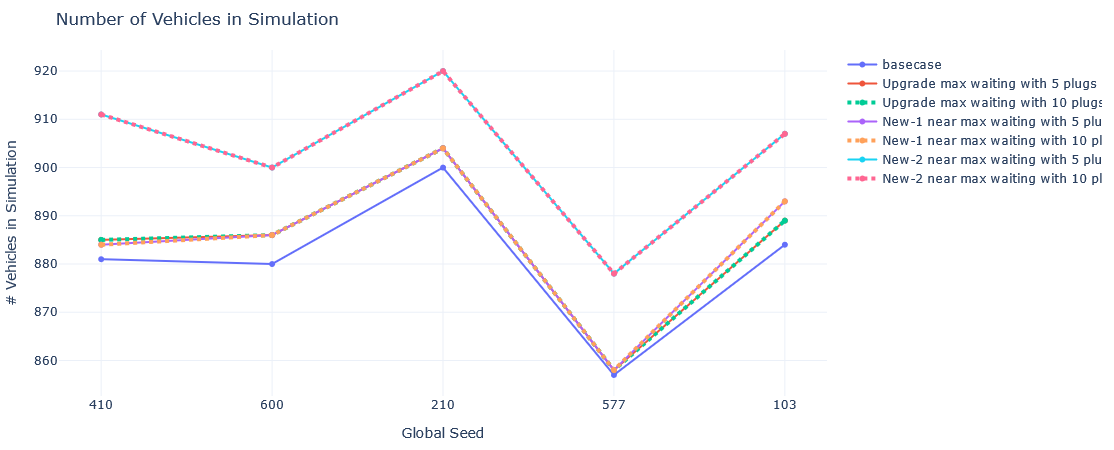

In [39]:
# EVs in simulation
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(500 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 504)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(506 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 510)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(511 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 515)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(516 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 520)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New-1 near max waiting with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(521 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 525)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New-1 near max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(526 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 530)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New-2 near max waiting with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(531 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 535)].sort_values('analysis_id')['sim_count'],
                    mode='lines+markers',
                    name='New-2 near max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title="Number of Vehicles in Simulation",
        yaxis_title="# Vehicles in Simulation", 
        xaxis_title="Global Seed")
fig.show()

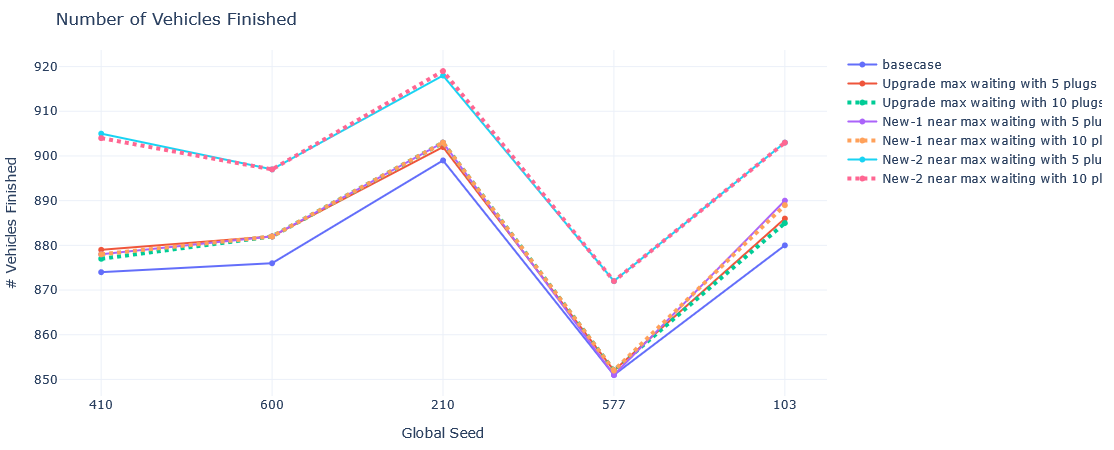

In [40]:
# EVs finished
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(500 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 504)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(506 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 510)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(511 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 515)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(516 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 520)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New-1 near max waiting with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(521 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 525)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New-1 near max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(526 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 530)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New-2 near max waiting with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(531 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 535)].sort_values('analysis_id')['fin_count'],
                    mode='lines+markers',
                    name='New-2 near max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title="Number of Vehicles Finished",
        yaxis_title="# Vehicles Finished", 
        xaxis_title="Global Seed")
fig.show()

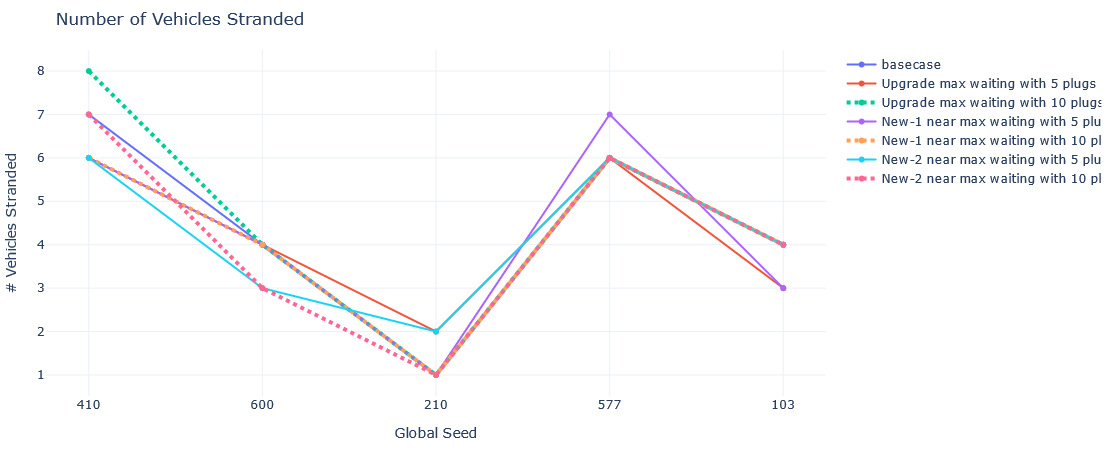

In [41]:
# EVs stranded
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(500 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 504)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(506 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 510)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(511 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 515)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(516 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 520)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New-1 near max waiting with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(521 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 525)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New-1 near max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(526 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 530)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New-2 near max waiting with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(531 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 535)].sort_values('analysis_id')['str_count'],
                    mode='lines+markers',
                    name='New-2 near max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title="Number of Vehicles Stranded",
        yaxis_title="# Vehicles Stranded", 
        xaxis_title="Global Seed")
fig.show()

## 5.2 eVMT

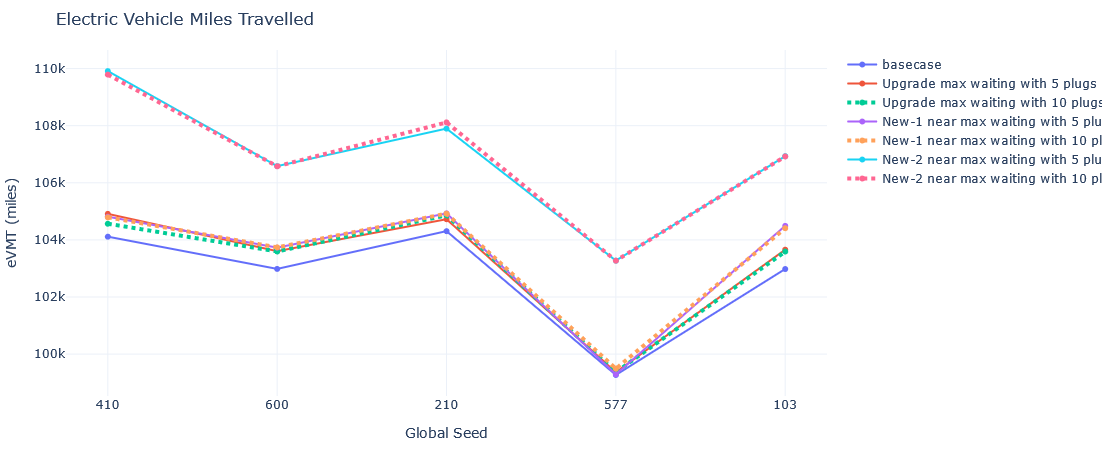

In [42]:
# evmt
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(500 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 504)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(506 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 510)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(511 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 515)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(516 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 520)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New-1 near max waiting with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(521 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 525)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New-1 near max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(526 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 530)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New-2 near max waiting with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(531 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 535)].sort_values('analysis_id')['evmt'],
                    mode='lines+markers',
                    name='New-2 near max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title="Electric Vehicle Miles Travelled",
        yaxis_title="eVMT (miles)", 
        xaxis_title="Global Seed")
fig.show()

#### 5.3 Charging and Waiting Sessions

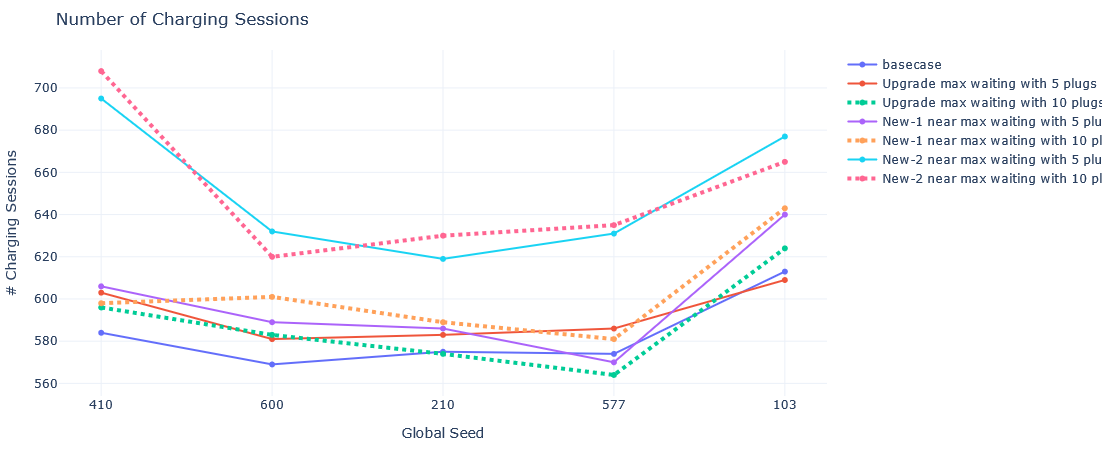

In [43]:
# charging_sessions count
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(500 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 504)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(506 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 510)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(511 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 515)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(516 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 520)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New-1 near max waiting with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(521 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 525)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New-1 near max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(526 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 530)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New-2 near max waiting with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(531 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 535)].sort_values('analysis_id')['cs_count'],
                    mode='lines+markers',
                    name='New-2 near max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title="Number of Charging Sessions",
        yaxis_title="# Charging Sessions", 
        xaxis_title="Global Seed")
fig.show()

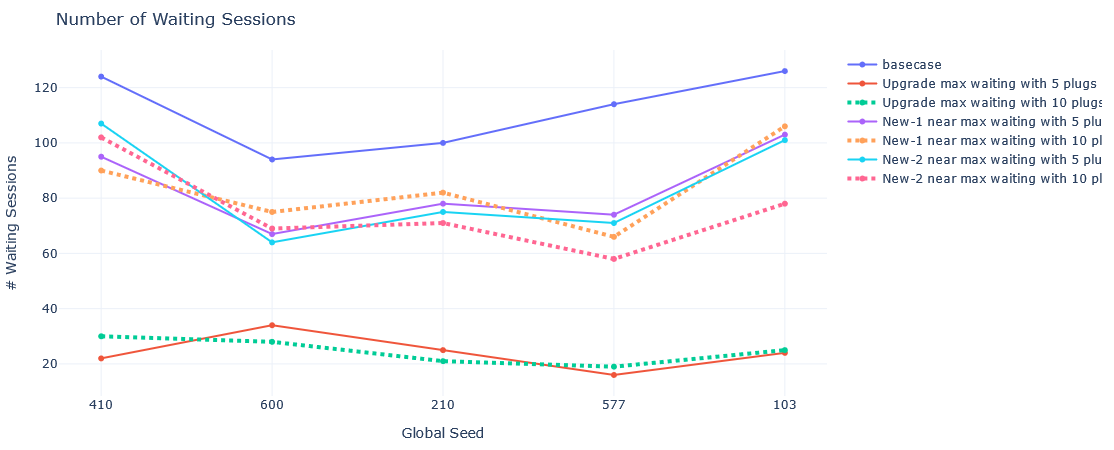

In [44]:
# waiting session count
fig = go.Figure()
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(500 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 504)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='basecase'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(506 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 510)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(511 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 515)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='Upgrade max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(516 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 520)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New-1 near max waiting with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(521 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 525)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New-1 near max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(526 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 530)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New-2 near max waiting with 5 plugs'))
fig.add_trace(go.Scatter(x=seeds, y=count_stats[(531 <= count_stats['analysis_id']) & (count_stats['analysis_id']<= 535)].sort_values('analysis_id')['wait_count'],
                    mode='lines+markers',
                    name='New-2 near max waiting with 10 plugs', line=dict(width=4, dash='dot')))
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=50, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', title="Number of Waiting Sessions",
        yaxis_title="# Waiting Sessions", 
        xaxis_title="Global Seed")
fig.show()

In [37]:
token = os.getenv("MAPBOX_ACCESS_TOKEN")
# analysis_ids = new_evses['analysis_id'].unique()

In [48]:
fig = go.Figure()
fig.add_trace(go.Scattermapbox(
        lat=all_be_cs['latitude'],
        lon=all_be_cs['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            opacity=0.8, 
            color='#EC912D'
        ),
        hoverinfo='none', 
    name='Non-tesla Fast Charging Stations'
    ))
fig.add_trace(go.Scattermapbox(
        lat=be_ws['latitude'],
        lon=be_ws['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            opacity=1
        ),
        hoverinfo='none', 
    name='Top 5 charging stations in # waiting sessions'
    ))
fig.add_trace(go.Scattermapbox(
        lat=ne_ws[ne_ws['analysis_id'] == 520]['latitude'],
        lon=ne_ws[ne_ws['analysis_id'] == 520]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            opacity=1
        ),
        hoverinfo='none', 
    name='New-1 near top 5 in # waiting sessions'
    ))
fig.add_trace(go.Scattermapbox(
        lat=ne_ws[ne_ws['analysis_id'] == 526]['latitude'],
        lon=ne_ws[ne_ws['analysis_id'] == 526]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            opacity=1
        ),
        hoverinfo='none', 
    name='New-2 near top 5 in # waiting sessions'
    ))
fig.update_layout(
        title_text = 'Locations of charging stations',
        showlegend = True,
        mapbox_style="streets", mapbox_accesstoken=token,
        mapbox_zoom=6, mapbox_center = {"lat":  47.7511, "lon": -120.7401}, 
        width=1000, 
        height=700, legend=dict(
    yanchor="top",
    y=0.8,
    xanchor="right",
    x=0.9
)
    )

fig.show()

In [ ]:
a_ids

____________
____________

Things to do the first time if the plotly plots not showing. Restart jupyter lab after. 

In [ ]:
#!jupyter labextension list

In [ ]:
#!jupyter labextension uninstall jupyterlab-plotly

In [ ]:
#!jupyter labextension uninstall plotlywidget

In [ ]:
#!export NODE_OPTIONS=--max-old-space-size=4096

In [ ]:
#!pip show plotly

In [ ]:
#!pip install jupyterlab "ipywidgets>=7.5"

In [ ]:
#!jupyter labextension install jupyterlab-plotly@4.12.0

In [ ]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.12.0

In [ ]:
#!pip install "nbconvert<6"